## Modelo Pronóstico Oceanic Niño Index (ONI) - Pantaleon Sugar Holdings


**El Niño (La Niña)** es un fenómeno en el Océano Pacífico Ecuatorial caracterizado por una media móvil consecutiva trimestral de anomalías en la temperatura superficial del océano (Sea Surface Temperature o SST) en la *región Niño 3.4* que está por arriba (o por debajo) del umbral de +0.5°C (-0.5°C). A éste estándar de medición se le conoce como el **Índice Océanico del Niño** (Oceanic Niño Index ONI).

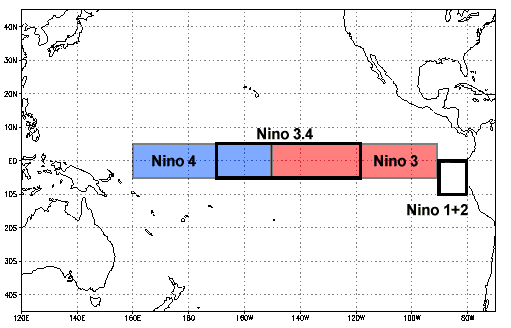


Se presenta un modelo de Deep Learning para el pronóstico del valor de Índice Oceánico de El Niño, que representa el índice que traza el patrón climático de la zona océanica ENSO (ver referencias abajo). El ONI es la media móvil trimestral de las anomalías (diferencias respecto a la media) en la superficie de la región centro-oriental tropical del océano Pacífico, cercana a la línea internacional del cambio de fecha.

*   https://ggweather.com/enso/oni.htm
*   https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php

El ONI es importante para categorizar los efectos NIÑO o NIÑA en una escala DÉBIL, MODERADA, FUERTE y MUY FUERTE.
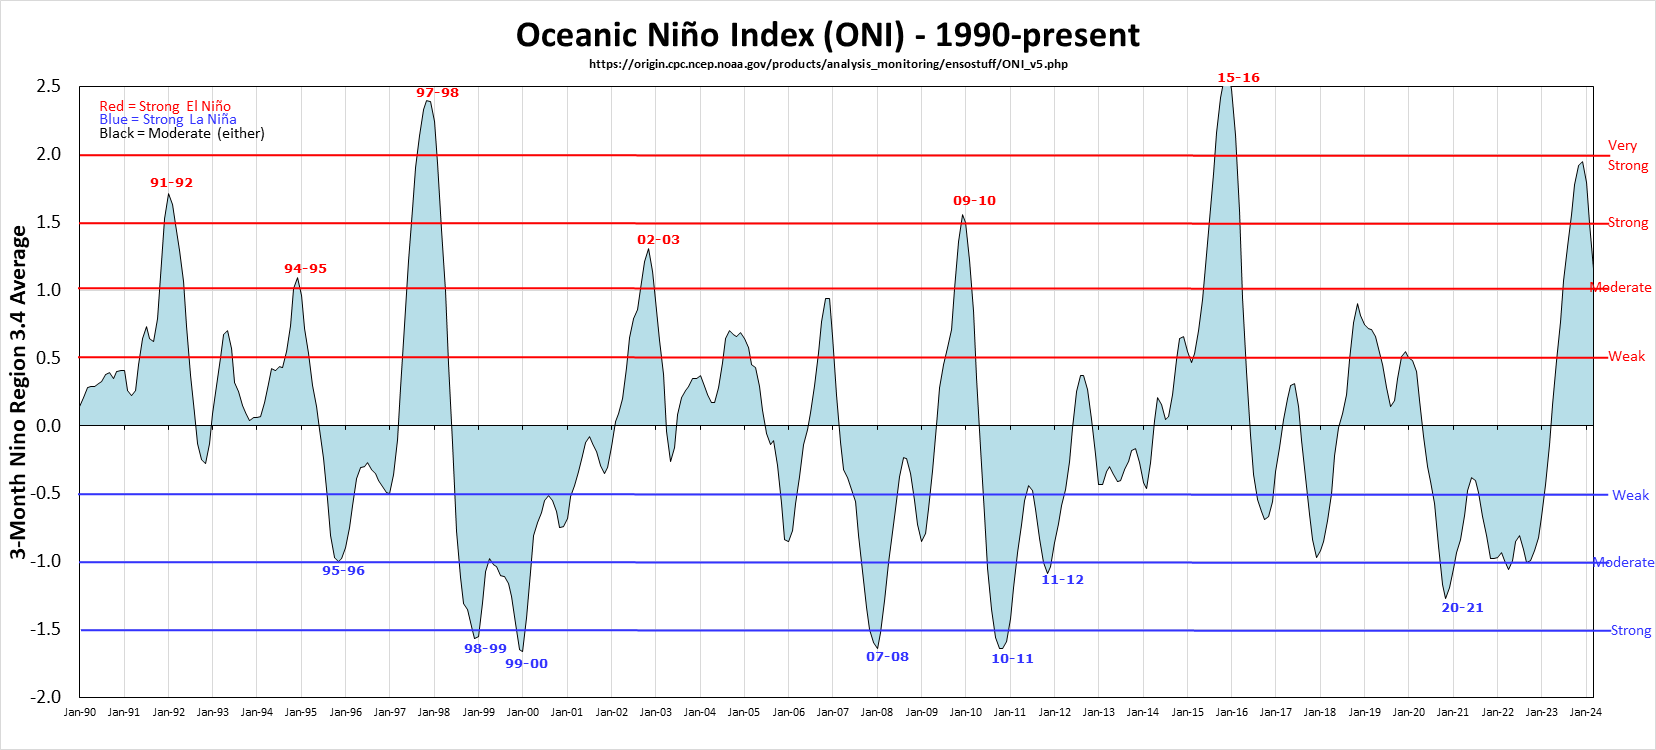
El siguiente trabajo de modelado utiliza una Red Neuronal Recurrente para Series de Tiempo, que permite pronosticar futuros valores del ONI por mes. Este modelamiento se realiza sobre los datos registrados del ONI desde el año 1950 por el National Weather Service del Centro de Predicción Climática (CPC) de los Estados Unidos.

In [3]:
# DS Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

# Deep Learning Framework
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.saving import load_model

#### Dataset Oceanic Niño Index
- https://www.ncei.noaa.gov/access/monitoring/enso/sst
- https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt

In [4]:
# .csv de Anomialias ONI
oni_df = pd.read_csv("ONI_2024.csv")
oni_df.head()

,SEAS,YR,TOTAL,ANOM
0,DJF,1950,24.72,-1.53
1,JFM,1950,25.17,-1.34
2,FMA,1950,25.75,-1.16
3,MAM,1950,26.12,-1.18
4,AMJ,1950,26.32,-1.07


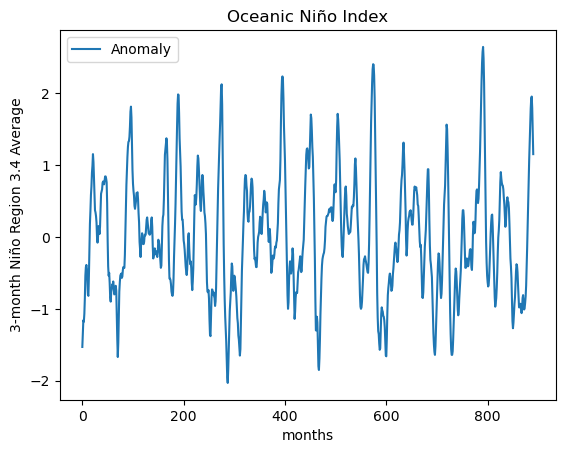

In [9]:
anom = oni_df['ANOM']
anom.plot()
plt.title('Oceanic Niño Index')
plt.ylabel('3-month Niño Region 3.4 Average')
plt.xlabel('months')
plt.legend(['Anomaly'], loc='upper left')


#### Evaluation Functions

In [10]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [11]:
def plot_train_metrics(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [12]:
def plot_predictions(model, X, y):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  plt.plot(df['Predictions'])
  plt.plot(df['Actuals'])
  plt.title('Predictions vrs. Actuals') 
  plt.ylabel('ONI')
  plt.xlabel('month')
  plt.legend(['Predictions', 'Actuals'], loc='upper left')
  return df, mse(predictions, y)

### Modelo de Recurrencia One-Month-Ahead

Se define la estructura de datos para utilizar en los modelos de recurrencia.
One-Month-Ahead es un modelo que utiliza una Red Neuronal Recurrente (LSTM, GRU o CNN) en la que valores anteriores (determinados por el WINDOW_SIZE) se utilizan para pronosticar el valor inmediato siguiente. En el ejemplo, se muestra para un WINDOW_SIZE de 5 la estructura de datos recurrente:

- $X_{Month_6} = \{ONI_{Month_1},ONI_{Month_2},ONI_{Month_3},ONI_{Month_4},ONI_{Month_5}\}$ para pronosticar $y_{Month_6}=ONI_{Month_6}$
- $X_{Month_7} = \{ONI_{Month_2},ONI_{Month_3},ONI_{Month_4},ONI_{Month_5},ONI_{Month_6}\}$ para pronosticar $y_{Month_7}=ONI_{Month_7}$


    $\vdots{}$

- $X_{Month_t} = \{ONI_{Month_{t-5}},ONI_{Month_{t-4}},ONI_{Month_{t-3}},ONI_{Month_{t-2}},ONI_{Month_{t-1}}\}$ para pronosticar $y_{Month_t}=ONI_{Month_t}$

In [13]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(anom, WINDOW_SIZE)
X1.shape, y1.shape

((886, 5, 1), (886,))

#### Train - Validation - Test Split
Separación del dataset en conjuntos de Entrenamiento, Validación y Test.

- El conjunto de Entrenamiento se utiliza para encontrar los parámetros del modelo de Deep Learning que minimice el error de predicción.
- El conjunto de Validación se oculta al modelo y se usa para verificar el error real de predicción con datos nunca vistos.
- El conjunto de Test se oculta al modelo y se usa para verificar su capacidad de generalizar a datos del futuro.



In [23]:
ratio_split = 0.7

In [24]:
# Train - Validation - Test Split
train_index = round(y1.shape[0]*ratio_split*ratio_split)
val_index = round(y1.shape[0]*ratio_split)

X_train1, y_train1 = X1[:train_index], y1[:train_index]
X_val1, y_val1 = X1[train_index:val_index], y1[train_index:val_index]
X_test1, y_test1 = X1[val_index:], y1[val_index:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((434, 5, 1), (434,), (186, 5, 1), (186,), (266, 5, 1), (266,))

### LSTM
https://en.wikipedia.org/wiki/Long_short-term_memory

In [25]:
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
cp1 = ModelCheckpoint('oni_model_LSTM/checkpoint.model.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [27]:
history = model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp1])

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5106 - root_mean_squared_error: 0.7148 - val_loss: 0.5732 - val_root_mean_squared_error: 0.7676
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4009 - root_mean_squared_error: 0.6328 - val_loss: 0.5182 - val_root_mean_squared_error: 0.7299
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3713 - root_mean_squared_error: 0.6100 - val_loss: 0.4604 - val_root_mean_squared_error: 0.6879
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3526 - root_mean_squared_error: 0.5916 - val_loss: 0.3732 - val_root_mean_squared_error: 0.6192
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2287 - root_mean_squared_error: 0.4774 - val_loss: 0.2582 - val_root_mean_squared_error: 0.5146
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1868 - root_mean_squared_error: 0.4324 - val_loss: 0.2124 - val_root_mean_squared_error: 0.4666
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

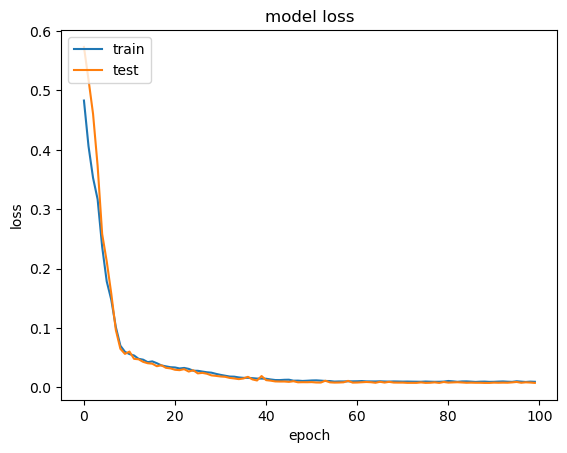

In [28]:
plot_train_metrics(history)

In [29]:
model1 = load_model('oni_model_LSTM/checkpoint.model.keras')

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


(     Predictions  Actuals
 0      -0.916133    -0.85
 1      -0.688969    -0.54
 2      -0.317316    -0.42
 3      -0.432873    -0.39
 4      -0.379646    -0.44
 ..           ...      ...
 429    -0.383436    -0.31
 430    -0.158979    -0.20
 431    -0.151994    -0.12
 432    -0.065033    -0.04
 433     0.025444     0.22
 
 [434 rows x 2 columns],
 0.009281785154446245)

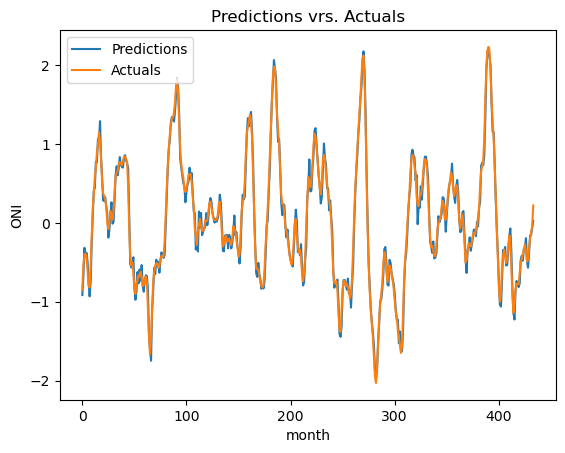

In [31]:
plot_predictions(model1, X_train1, y_train1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step


(     Predictions  Actuals
 0       0.468353     0.44
 1       0.574031     0.71
 2       0.931226     0.94
 3       1.106489     1.14
 4       1.290600     1.22
 ..           ...      ...
 181    -0.181730    -0.19
 182    -0.219141    -0.29
 183    -0.364876    -0.35
 184    -0.365417    -0.31
 185    -0.243506    -0.15
 
 [186 rows x 2 columns],
 0.007738590875358064)

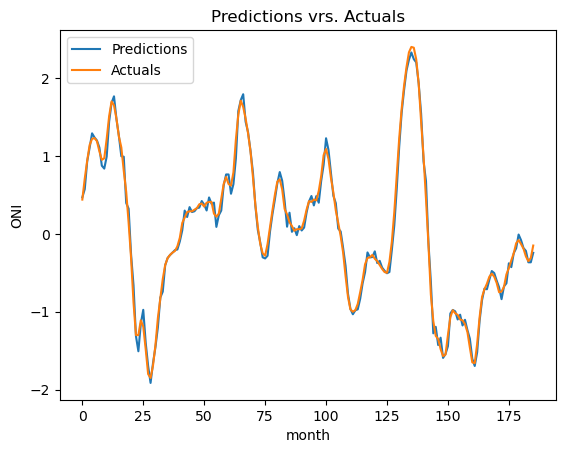

In [32]:
plot_predictions(model1, X_val1, y_val1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step


(     Predictions  Actuals
 0      -0.003468     0.03
 1       0.153326     0.09
 2       0.093551     0.20
 3       0.310298     0.43
 4       0.635677     0.65
 ..           ...      ...
 261     1.902143     1.92
 262     1.922179     1.95
 263     1.837875     1.79
 264     1.494525     1.49
 265     1.136147     1.15
 
 [266 rows x 2 columns],
 0.006971154683399136)

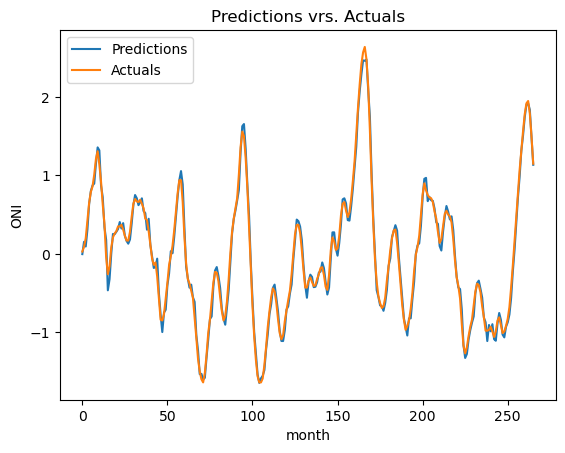

In [33]:
plot_predictions(model1, X_test1, y_test1)

### Convolutional Neural Network

https://en.wikipedia.org/wiki/Convolutional_neural_network

In [34]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2, activation='relu'))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257 (8.82 KB)

 Trainable params: 2,257 (8.82 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
cp2 = ModelCheckpoint('oni_model_CNN/checkpoint.model.keras', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [36]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp2])

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6225 - root_mean_squared_error: 0.7884 - val_loss: 0.4957 - val_root_mean_squared_error: 0.7109
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2803 - root_mean_squared_error: 0.5296 - val_loss: 0.2558 - val_root_mean_squared_error: 0.5118
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1943 - root_mean_squared_error: 0.4397 - val_loss: 0.1709 - val_root_mean_squared_error: 0.4184
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1234 - root_mean_squared_error: 0.3518 - val_loss: 0.1149 - val_root_mean_squared_error: 0.3430
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0837 - root_mean_squared_error: 0.2891 - val_loss: 0.0764 - val_root_mean_squared_error: 0.2795
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0626 - root_mean_squared_error: 0.2498 - val_loss: 0.0564 - val_root_mean_squared_error: 0.2400
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

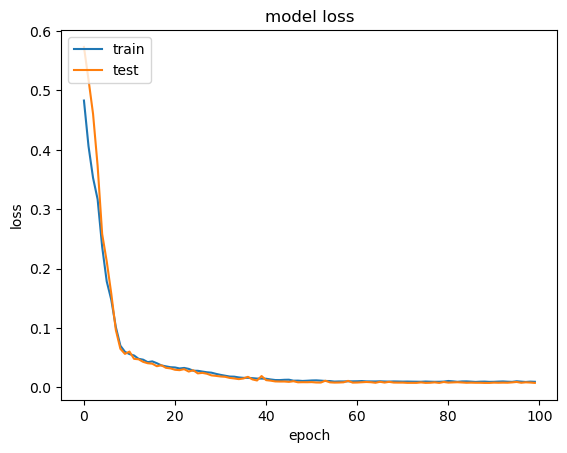

In [37]:
plot_train_metrics(history)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


(     Predictions  Actuals
 0       0.020508     0.03
 1       0.182642     0.09
 2       0.115569     0.20
 3       0.339265     0.43
 4       0.712781     0.65
 ..           ...      ...
 261     1.970623     1.92
 262     2.006846     1.95
 263     1.935146     1.79
 264     1.616926     1.49
 265     1.223367     1.15
 
 [266 rows x 2 columns],
 0.010194099025464943)

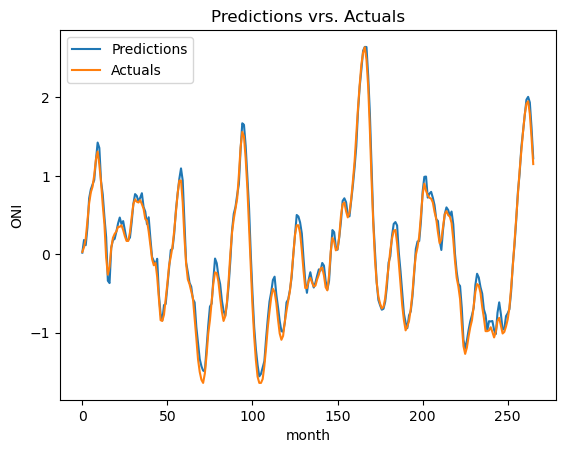

In [38]:
plot_predictions(model2, X_test1, y_test1)

### GRU

https://en.wikipedia.org/wiki/Gated_recurrent_unit

In [39]:
model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,393 (52.32 KB)

 Trainable params: 13,393 (52.32 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
cp3 = ModelCheckpoint('oni_model_GRU/checkpoint.model.keras', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [41]:
history = model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp3])

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5834 - root_mean_squared_error: 0.7632 - val_loss: 0.5955 - val_root_mean_squared_error: 0.7821
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4481 - root_mean_squared_error: 0.6671 - val_loss: 0.5183 - val_root_mean_squared_error: 0.7299
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3274 - root_mean_squared_error: 0.5706 - val_loss: 0.3561 - val_root_mean_squared_error: 0.6050
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2421 - root_mean_squared_error: 0.4917 - val_loss: 0.2175 - val_root_mean_squared_error: 0.4723
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1586 - root_mean_squared_error: 0.3983 - val_loss: 0.1712 - val_root_mean_squared_error: 0.4190
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1185 - root_mean_squared_error: 0.3436 - val_loss: 0.1258 - val_root_mean_squared_error: 0.3589
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

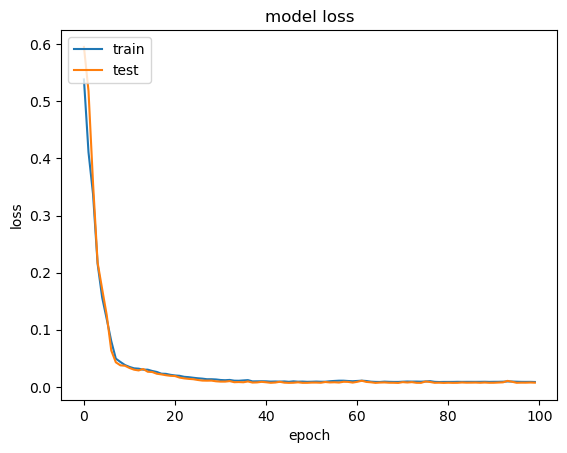

In [42]:
plot_train_metrics(history)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


(     Predictions  Actuals
 0       0.012621     0.03
 1       0.163765     0.09
 2       0.100492     0.20
 3       0.333708     0.43
 4       0.704532     0.65
 ..           ...      ...
 261     1.945463     1.92
 262     1.961113     1.95
 263     1.874269     1.79
 264     1.547495     1.49
 265     1.177516     1.15
 
 [266 rows x 2 columns],
 0.007162546827442591)

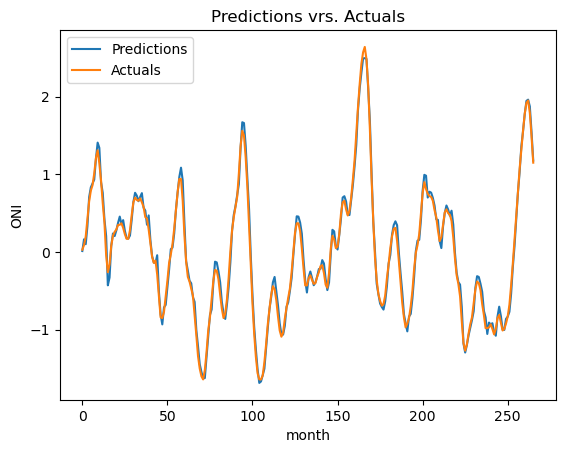

In [43]:
plot_predictions(model3, X_test1, y_test1)

#### Conclusiones:

Los modelos RNN presentados muestran los siguientes resultados:

|Modelo|RMSE en Test|# parámetros|
|------|----|------------|
|Long Short-Term Memory|0.00697|17,425|
|Convolutional Neural Network|0.01019|2,257|
|Gated recurrent unit|0.00716|13,393|

Dado que este modelo es One-Month-Ahead utilizando auto-regresión simple únicamente, se recomienda utiizar el LSTM por tener la mayor capacidad de generalizar. El número de parámetros no llega a ser un reto computacional, como lo sería con una regresión multivariable y también en el caso multi-step (varios meses adelante).
